In [3]:
from utils import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 40)

In [4]:
# boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

NameError: name 'reviews_filtered' is not defined

<Figure size 800x500 with 0 Axes>

## 5. Statistical Analysis 📈

### 5.1 Measure the impact of each aspect on rating 📏
> First draft analysis to look which aspect has more impact on the rating. We will continue this analysis in P3.

In [5]:
df = pd.read_parquet(dataset_path + 'BA_04_complete.parquet')

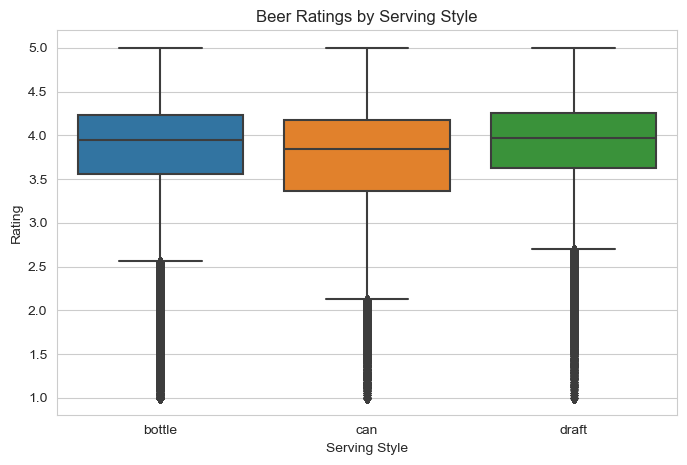

In [15]:
# do a box plot for the ratings depending on the serving style : bottle first, then can and finally draft
serving_type_order = ['bottle', 'can', 'draft']
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, y='rating', x='serving_type_rulebased', order=serving_type_order)
plt.title('Beer Ratings by Serving Style')
plt.xlabel('Serving Style')
plt.ylabel('Rating')
plt.show()

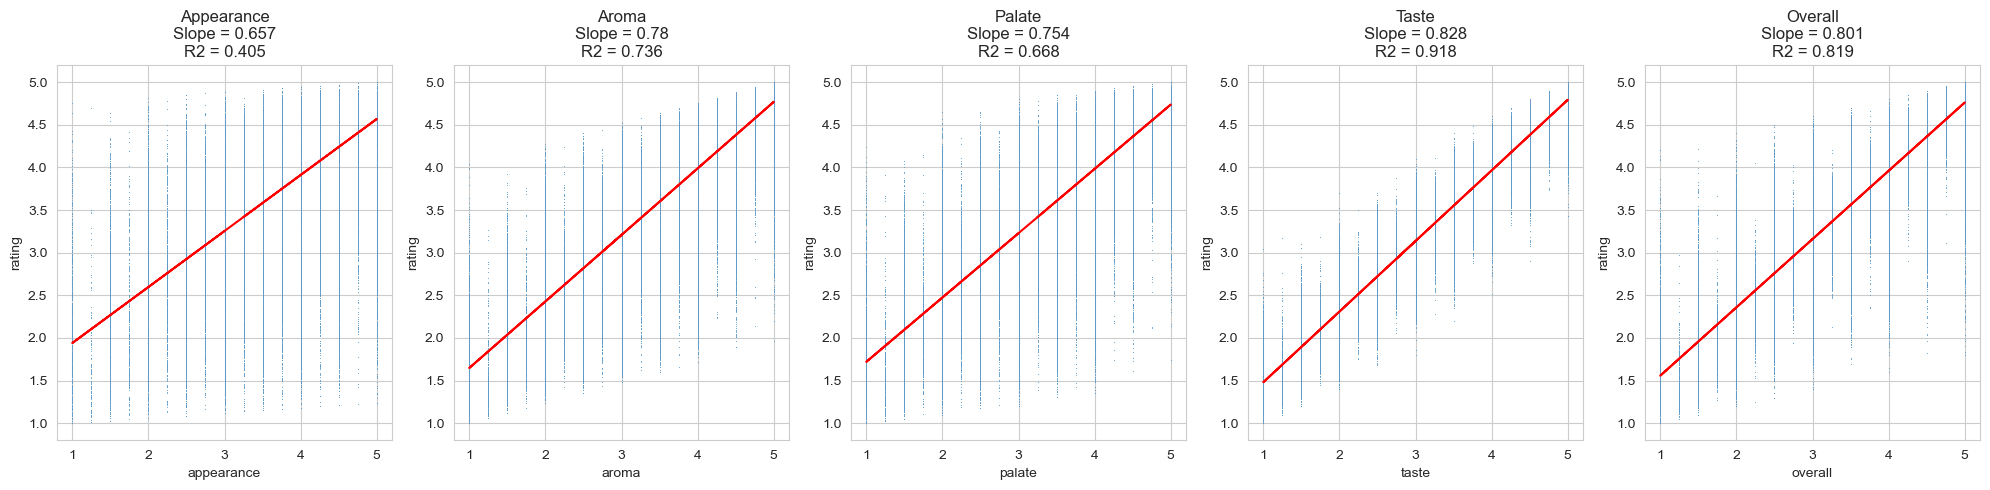

In [3]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

> It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### 5.2 Hypothesis testing on the new labels

In [4]:
def do_ttest(type1: str, type2: str, category: str) -> None:
    """
    Perform a t-test on the two samples of the given category for the given serving types.
    
    Parameters:
    - type1 (str): The first serving type.
    - type2 (str): The second serving type.
    - category (str): The category to perform the t-test on.

    """
    ttest = ttest_ind(df[df['serving_type_rulebased'] == type1][category],df[df['serving_type_rulebased'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

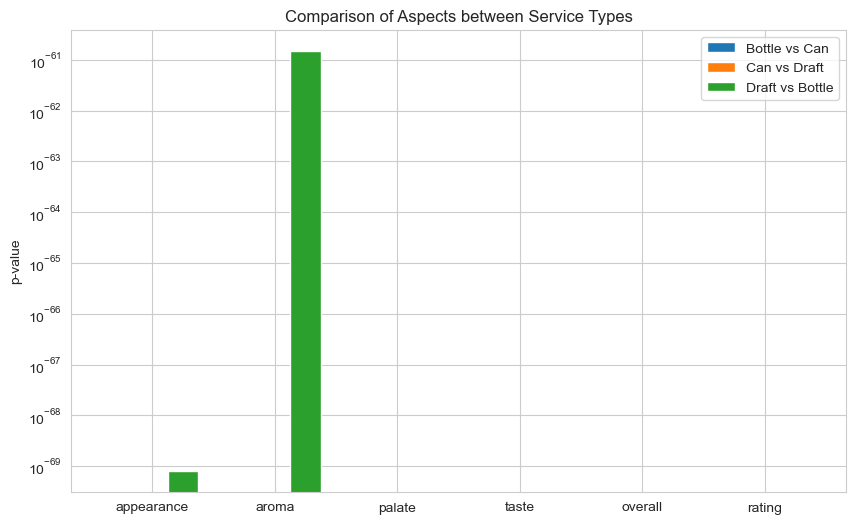

In [5]:
# compare each aspect between all three serving types

# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type_rulebased'] == 'bottle'][columns[i]], df[df['serving_type_rulebased'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type_rulebased'] == 'can'][columns[i]], df[df['serving_type_rulebased'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type_rulebased'] == 'draft'][columns[i]], df[df['serving_type_rulebased'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

In [47]:
# Create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# Perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type_rulebased'] == 'bottle'][columns[i]], df[df['serving_type_rulebased'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type_rulebased'] == 'can'][columns[i]], df[df['serving_type_rulebased'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type_rulebased'] == 'draft'][columns[i]], df[df['serving_type_rulebased'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# Set color variation for each serving type
colors = {'bottle': 'royalblue', 'can': 'cornflowerblue', 'draft': 'lightsteelblue'}

# Create grouped bar chart
fig = go.Figure()

for i, serving_type in enumerate(['Bottle vs Can', 'Can vs Draft', 'Draft vs Bottle']):
    fig.add_trace(go.Bar(
        x=columns,
        y=p_values[:, i],
        name=serving_type,
        marker_color=colors[serving_type.split(' vs ')[0].lower()],  # Use color from the variation of blue
    ))

# Update layout
fig.update_layout(
    yaxis_type='log',
    xaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
    yaxis=dict(title='p-value'),
    title='Comparison of Aspects between Service Types',
    barmode='group',
    legend=dict(title='Comparison'),
)

# Show the plot
fig.write_html('plots/BA_04_ttest.html')
fig.show()



> All the p-values are below 0.05, so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

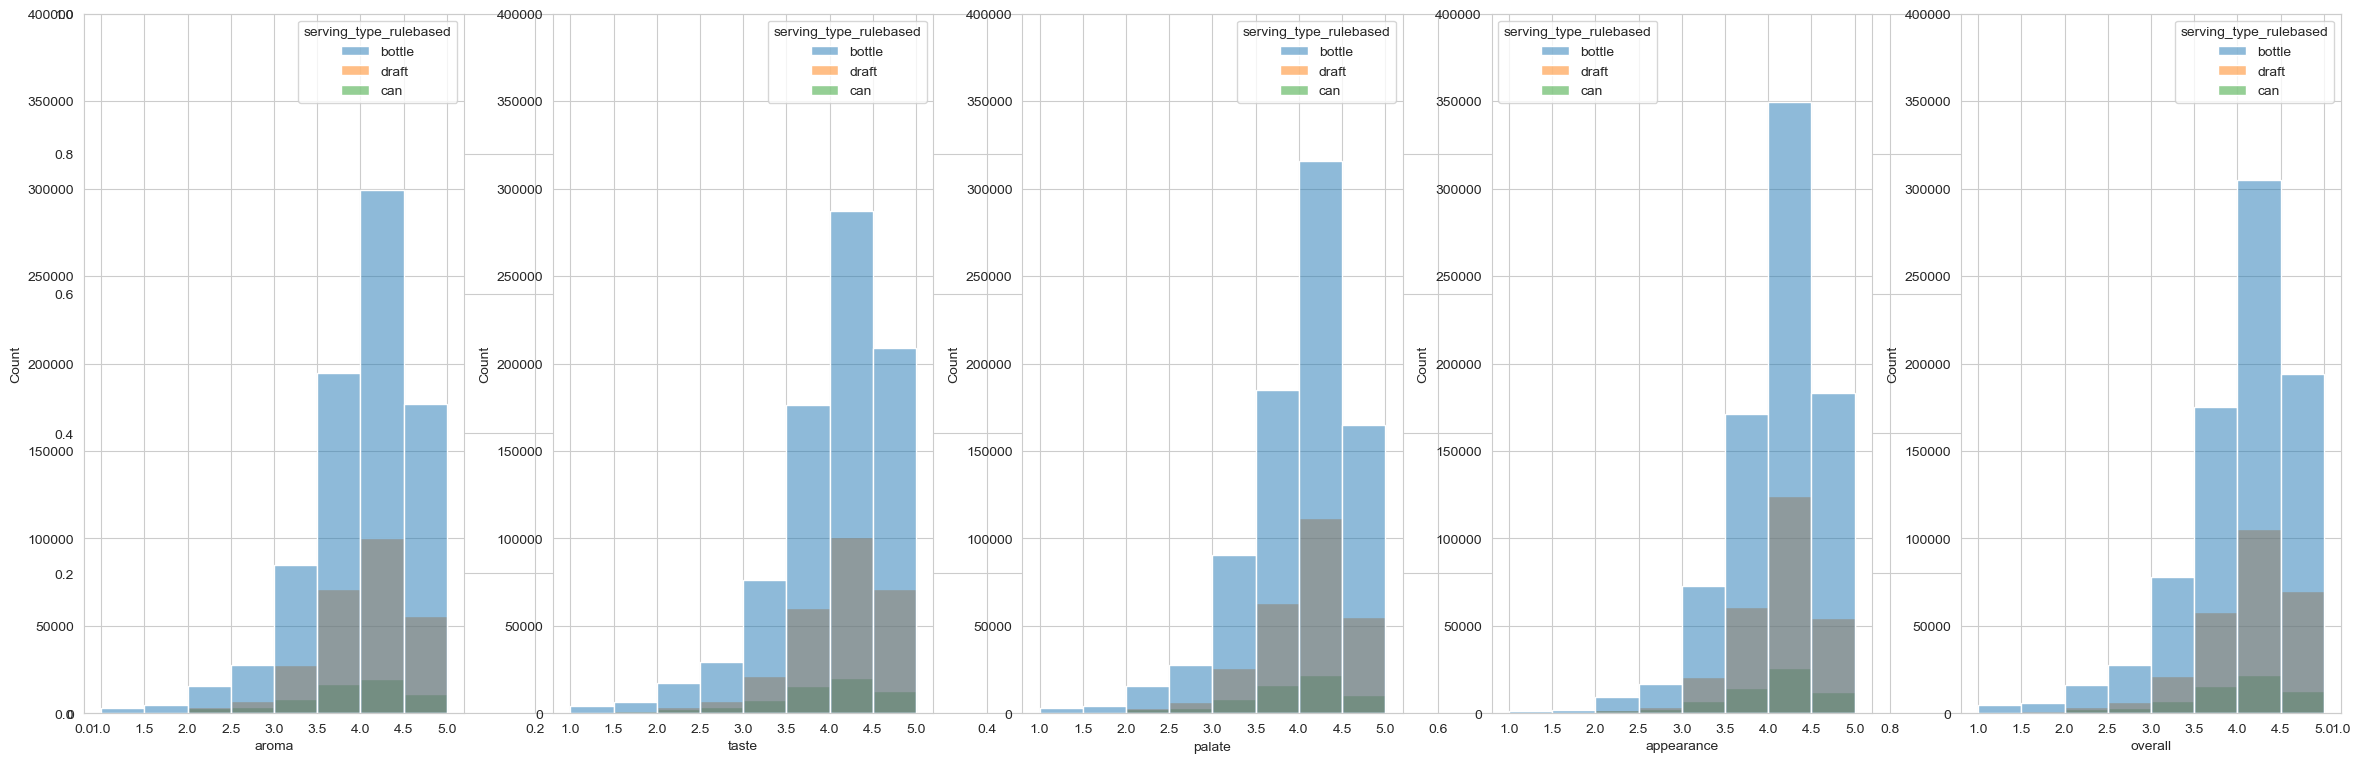

In [6]:
# Task 7.3 : analysis of the serving style on the ratings and tasting palette
# Histogram of the ratings for each serving type
plt.subplots(figsize=(24, 8))
plt.subplot(151)
sns.histplot(data=df, hue='serving_type_rulebased', x='aroma', binwidth=0.5)
plt.ylim(0, 400000)
plt.subplot(152)
sns.histplot(data=df, hue='serving_type_rulebased', x='taste', binwidth=0.5)
plt.ylim(0, 400000)
plt.subplot(153)
sns.histplot(data=df, hue='serving_type_rulebased', x='palate', binwidth=0.5)
plt.ylim(0, 400000)
plt.subplot(154)
sns.histplot(data=df, hue='serving_type_rulebased', x='appearance', binwidth=0.5)
plt.ylim(0, 400000)
plt.subplot(155)
sns.histplot(data=df, hue='serving_type_rulebased', x='overall', binwidth=0.5)
plt.ylim(0, 400000)
plt.tight_layout()
plt.show()

In [11]:
# Create histograms for each tasting aspect
fig = px.histogram(df, x='aroma', color='serving_type_rulebased', marginal='rug', nbins=20, opacity=0.7,
                   category_orders={'serving_type_rulebased': ['bottle', 'can', 'draft']},
                   labels={'aroma': 'Aroma'},
                   title='Histogram of Ratings for Each Serving Type')

# Add histograms for other tasting aspects
fig.add_trace(px.histogram(df, x='taste', color='serving_type_rulebased', marginal='rug', nbins=20, opacity=0.7,
                            category_orders={'serving_type_rulebased': ['bottle', 'can', 'draft']},
                            labels={'taste': 'Taste'}).data[0])

fig.add_trace(px.histogram(df, x='palate', color='serving_type_rulebased', marginal='rug', nbins=20, opacity=0.7,
                            category_orders={'serving_type_rulebased': ['bottle', 'can', 'draft']},
                            labels={'palate': 'Palate'}).data[0])

fig.add_trace(px.histogram(df, x='appearance', color='serving_type_rulebased', marginal='rug', nbins=20, opacity=0.7,
                            category_orders={'serving_type_rulebased': ['bottle', 'can', 'draft']},
                            labels={'appearance': 'Appearance'}).data[0])

fig.add_trace(px.histogram(df, x='overall', color='serving_type_rulebased', marginal='rug', nbins=20, opacity=0.7,
                            category_orders={'serving_type_rulebased': ['bottle', 'can', 'draft']},
                            labels={'overall': 'Overall'}).data[0])

# Update trace names and colors
fig.for_each_trace(lambda t: t.update(name=t.name.replace('serving_type_rulebased=', ''),
                                      marker_color='blue' if 'bottle' in t.name else ('orange' if 'can' in t.name else 'green')))

# Update layout
fig.update_layout(barmode='overlay', xaxis_title='Rating', yaxis_title='Count')

# Save the plot as an HTML file
fig.write_html('plots/histogram_plot.html')


We can first try to perform a statistical test on these distributions, that seem to have a normal shape.

In [8]:
from scipy.stats import kruskal

The Kruskal-Wallis test is robust to uneven sample sizes. Not sure about this though because this tests if the population median of all groups is different but does not indicate in which way.

In [9]:
#perform kruskal-wallis test to see if the ratings are independent of the serving type
result_aroma = kruskal(df[df['serving_type_rulebased'] == 'bottle']['aroma'], df[df['serving_type_rulebased'] == 'can']['aroma'], df[df['serving_type_rulebased'] == 'draft']['aroma'])
result_taste = kruskal(df[df['serving_type_rulebased'] == 'bottle']['taste'], df[df['serving_type_rulebased'] == 'can']['taste'], df[df['serving_type_rulebased'] == 'draft']['taste'])
result_palate = kruskal(df[df['serving_type_rulebased'] == 'bottle']['palate'], df[df['serving_type_rulebased'] == 'can']['palate'], df[df['serving_type_rulebased'] == 'draft']['palate'])
result_appearance = kruskal(df[df['serving_type_rulebased'] == 'bottle']['appearance'], df[df['serving_type_rulebased'] == 'can']['appearance'], df[df['serving_type_rulebased'] == 'draft']['appearance'])
result_overall = kruskal(df[df['serving_type_rulebased'] == 'bottle']['overall'], df[df['serving_type_rulebased'] == 'can']['overall'], df[df['serving_type_rulebased'] == 'draft']['overall'])
print('Aroma: p-value =', result_aroma.pvalue)
print('Taste: p-value =', result_taste.pvalue)
print('Palate: p-value =', result_palate.pvalue)
print('Appearance: p-value =', result_appearance.pvalue)
print('Overall: p-value =', result_overall.pvalue)

Aroma: p-value = 0.0
Taste: p-value = 0.0
Palate: p-value = 0.0
Appearance: p-value = 9.502259982712586e-259
Overall: p-value = 0.0


In [10]:
#import norm
from scipy.stats import norm

Let's fit a normal distribution

All the p-values are above 0.05 so we cannot reject the null hypothesis that the distributions are similar.

### 5.3 Comparison of the ratings between the serving styles for specific beer ids

In [12]:
df_match = df.groupby(['beer_id', 'serving_type_rulebased']).size().unstack().reset_index()
df_match.columns = ['beer_id', 'bottle', 'can', 'draft']
df_match.fillna(0, inplace=True)
df_match[['bottle', 'can', 'draft']] = df_match[['bottle', 'can', 'draft']].astype(int)

print('Shape of df_match:', df_match.shape)

# keep only beer that have at least n reviews for each serving type
n = 7
df_match = df_match[(df_match['bottle'] >= n) & (df_match['can'] >= n) & (df_match['draft'] >= n)].copy(deep=True)


display(df_match.sample(5))
print('Shape of df_match:', df_match.shape)

Shape of df_match: (115525, 4)


,beer_id,bottle,can,draft
6752,10071,120,120,23
7123,10731,26,10,8
1761,2212,106,7,44
3057,4108,189,9,38
765,910,27,84,53


Shape of df_match: (397, 4)


In [13]:
from scipy.stats import f_oneway

# Filter the DataFrame for the specified beer IDs
filtered_df = df[df['beer_id'].isin(df_match['beer_id'])]

In [14]:
filtered_df.shape

(133974, 53)

In [15]:
aspects = ['aroma', 'appearance', 'palate', 'taste', 'overall']
above_threshold = []
below_threshold = []

for aspect in aspects:
    above = 0
    below = 0
    
    for beer_id in tqdm(set(filtered_df['beer_id'])):
        # Filter the DataFrame for the specified beer ID
        filtered_df_specific = filtered_df[filtered_df['beer_id'] == beer_id]

        # Perform the one-way ANOVA test
        result = f_oneway(filtered_df_specific[filtered_df_specific['serving_type_rulebased'] == 'bottle'][aspect],
                          filtered_df_specific[filtered_df_specific['serving_type_rulebased'] == 'can'][aspect],
                          filtered_df_specific[filtered_df_specific['serving_type_rulebased'] == 'draft'][aspect])

        if result.pvalue < 0.05:
            above += 1
        else:
            below += 1
    
    above_threshold.append(above)
    below_threshold.append(below)
    print(f'The percentage of beers where the {aspect} is significantly different between serving types is {round(above / (above + below) * 100, 2)}%.\n')


100%|██████████| 397/397 [00:00<00:00, 1442.87it/s]


The percentage of beers where the aroma is significantly different between serving types is 12.59%.



100%|██████████| 397/397 [00:00<00:00, 1924.61it/s]


The percentage of beers where the appearance is significantly different between serving types is 14.61%.



100%|██████████| 397/397 [00:00<00:00, 1921.85it/s]


The percentage of beers where the palate is significantly different between serving types is 11.84%.



100%|██████████| 397/397 [00:00<00:00, 1793.45it/s]


The percentage of beers where the taste is significantly different between serving types is 18.14%.



100%|██████████| 397/397 [00:00<00:00, 1915.21it/s]

The percentage of beers where the overall is significantly different between serving types is 16.12%.



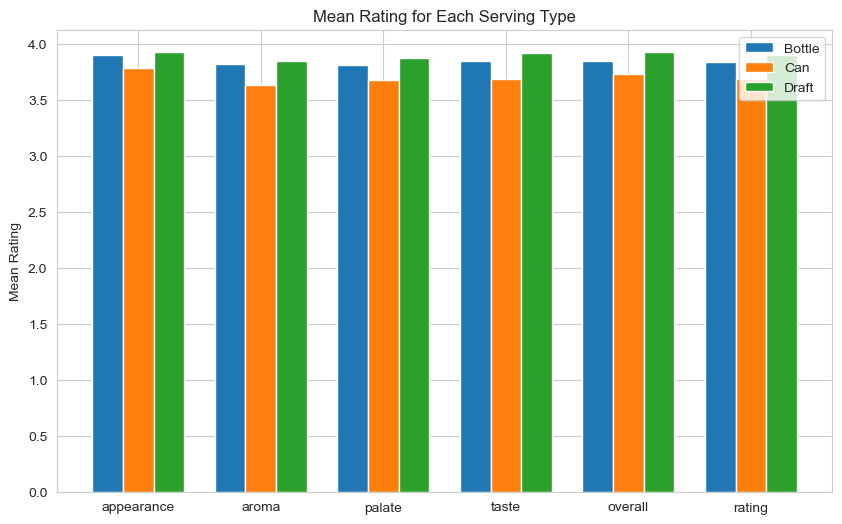

In [19]:
# plot for each aspect in the same figure the mean rating for each serving type, with confidence intervals
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
means = np.zeros((len(columns), 3))

for i in range(len(columns)):
    means[i][0] = df[df['serving_type_rulebased'] == 'bottle'][columns[i]].mean()
    means[i][1] = df[df['serving_type_rulebased'] == 'can'][columns[i]].mean()
    means[i][2] = df[df['serving_type_rulebased'] == 'draft'][columns[i]].mean()

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, means[:,0], width, label='Bottle')
rects2 = ax.bar(x, means[:,1], width, label='Can')
rects3 = ax.bar(x + width, means[:,2], width, label='Draft')
ax.set_xticks(x)
ax.set_xticklabels(columns)
ax.set_ylabel('Mean Rating')
ax.set_title('Mean Rating for Each Serving Type')
ax.legend()
plt.show()

In [48]:
# Define columns and serving types
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
serving_types = ['bottle', 'can', 'draft']  # Assuming these are the possible serving types

# Specify colors for each serving type
line_colors = {'bottle': 'blue', 'can': 'orange', 'draft': 'green'}

# Create a radar chart
fig = go.Figure()

# Add traces for each serving type
for serving_type in serving_types:
    data_subset = df[df['serving_type_rulebased'] == serving_type]
    
    # Calculate mean ratings and standard errors
    mean_ratings = data_subset[columns].mean()
    std_errors = data_subset[columns].sem()  # Assuming you want standard errors
    
    # Plot the mean ratings
    fig.add_trace(go.Scatterpolar(
        r=mean_ratings.values,
        theta=tuple(columns),  # Convert columns to tuple
        mode='markers+lines',
        name=serving_type,
        line=dict(color=line_colors[serving_type], width=2),  # Set line color
    ))

    # Plot the confidence interval as a filled line
    upper_bound = mean_ratings + 1.96 * std_errors
    lower_bound = mean_ratings - 1.96 * std_errors
    confidence_interval = pd.concat([upper_bound, lower_bound[::-1]])  # Concatenate in reverse order for a closed loop
    fig.add_trace(go.Scatterpolar(
        r=confidence_interval.values,
        theta=tuple(columns) + tuple(columns[::-1]),  # Convert columns and reverse to tuple
        fill='toself',  # Fill the area between the upper and lower bounds
        fillcolor=line_colors[serving_type],  # Set fill color with lower opacity
        line=dict(color='rgba(255,255,255,0)'),  # Set line color to transparent
        hoverinfo='skip',  # Skip hoverinfo for the filled area
        showlegend=True,  # Do not show legend for the filled area
    ))

# Update layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[3, 4]),  # Set the radial axis range
    ),
    showlegend=True,
    title='Mean Ratings for Different Aspects by Serving Type (Radar Chart)',
)

# Show the plot
fig.write_html('plots/radar_plot_aspect_serving.html')
fig.show()



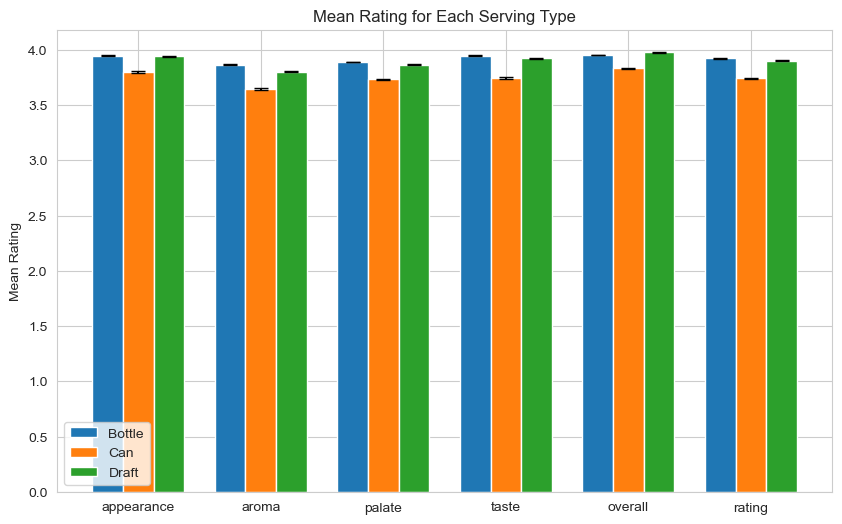

In [20]:
# calculate the means and standard errors
means = np.zeros((len(columns), 3))
std_errors = np.zeros((len(columns), 3))

for i in range(len(columns)):
    means[i][0] = filtered_df[filtered_df['serving_type_rulebased'] == 'bottle'][columns[i]].mean()
    means[i][1] = filtered_df[filtered_df['serving_type_rulebased'] == 'can'][columns[i]].mean()
    means[i][2] = filtered_df[filtered_df['serving_type_rulebased'] == 'draft'][columns[i]].mean()
    
    std_errors[i][0] = filtered_df[filtered_df['serving_type_rulebased'] == 'bottle'][columns[i]].sem()
    std_errors[i][1] = filtered_df[filtered_df['serving_type_rulebased'] == 'can'][columns[i]].sem()
    std_errors[i][2] = filtered_df[filtered_df['serving_type_rulebased'] == 'draft'][columns[i]].sem()

# create a table with the means and standard errors

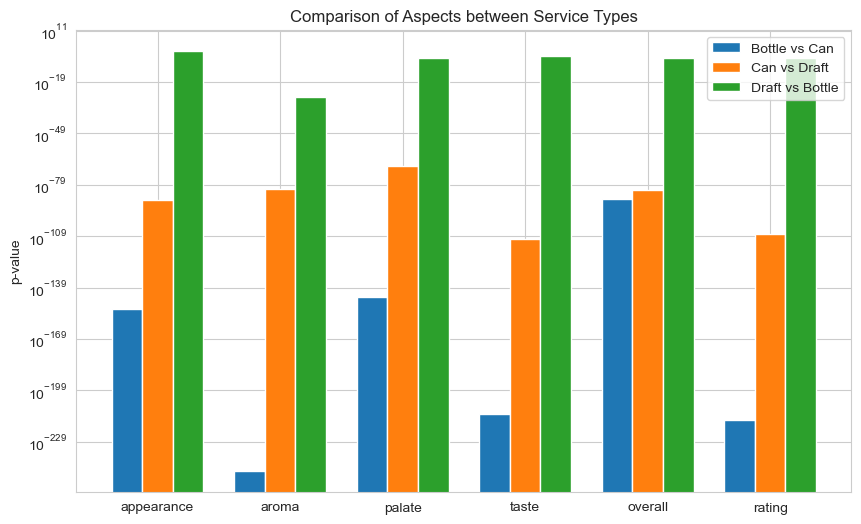

In [49]:

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(filtered_df[filtered_df['serving_type_rulebased'] == 'bottle'][columns[i]], filtered_df[filtered_df['serving_type_rulebased'] == 'can'][columns[i]])
    ttest2 = ttest_ind(filtered_df[filtered_df['serving_type_rulebased'] == 'can'][columns[i]], filtered_df[filtered_df['serving_type_rulebased'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(filtered_df[filtered_df['serving_type_rulebased'] == 'draft'][columns[i]], filtered_df[filtered_df['serving_type_rulebased'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

In [51]:
# Create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# Perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(filtered_df[filtered_df['serving_type_rulebased'] == 'bottle'][columns[i]], filtered_df[filtered_df['serving_type_rulebased'] == 'can'][columns[i]])
    ttest2 = ttest_ind(filtered_df[filtered_df['serving_type_rulebased'] == 'can'][columns[i]], filtered_df[filtered_df['serving_type_rulebased'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(filtered_df[filtered_df['serving_type_rulebased'] == 'draft'][columns[i]], filtered_df[filtered_df['serving_type_rulebased'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# Set color variation for each serving type
colors = {'bottle': 'royalblue', 'can': 'cornflowerblue', 'draft': 'lightsteelblue'}

# Create grouped bar chart
fig = go.Figure()

for i, serving_type in enumerate(['Bottle vs Can', 'Can vs Draft', 'Draft vs Bottle']):
    fig.add_trace(go.Bar(
        x=columns,
        y=p_values[:, i],
        name=serving_type,
        marker_color=colors[serving_type.split(' vs ')[0].lower()],  # Use color from the variation of blue
    ))

# Update layout
fig.update_layout(
    yaxis_type='log',
    xaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
    yaxis=dict(title='p-value'),
    title='Comparison of Aspects between Service Types',
    barmode='group',
    legend=dict(title='Comparison'),
)

# Save the plot as an HTML file
fig.write_html('plots/comparison_of_aspects.html')

# Show the plot
fig.show()


The p-values are still below the 0.05 threshold, and therefore we can reject the null hypothesis and conclude that there is a significant difference between the distributions.

> Once we were confident with the extracted serving styles, it was time to analyse and try to answer our initial question ! First, we looked at the distribution of the grades for each aspect of the tasting palette : aroma, palate, taste, appearance and overall grade, for each serving style. We did this using a t-test, which yielded each time a p-value lower than 0.05, suggesting that there was a statistically significant difference in these scores, based on the serving style. Then, we realized that the number of samples was very uneven between the serving styles (lots of bottles, moderate number of draft and a few cans), so we needed to find a test that was unsensitive to the sample size when comparing distributions : the Kruskal-Wallis test. This also yielded p-values very close to 0, suggesting once again that the distributions were different. But where does the difference come from ? Because we cannot affirm that we have not neglected some common confounders such as the beer group or some region of the world. Therefore, we started by filtering our data once more, to evaluate beers that had at least X reviews in each serving style, to control for that variable. But the results were very similar. This means that the difference in the ratings **does not come from the serving style!**